# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** first name and last name  
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

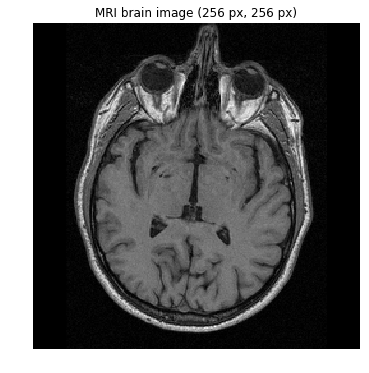

In [2]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

### 1.3 Contour detection
Add your implementation and discussion

### 1.4 Additional method(s)
Add your implementation and discussion

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [3]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


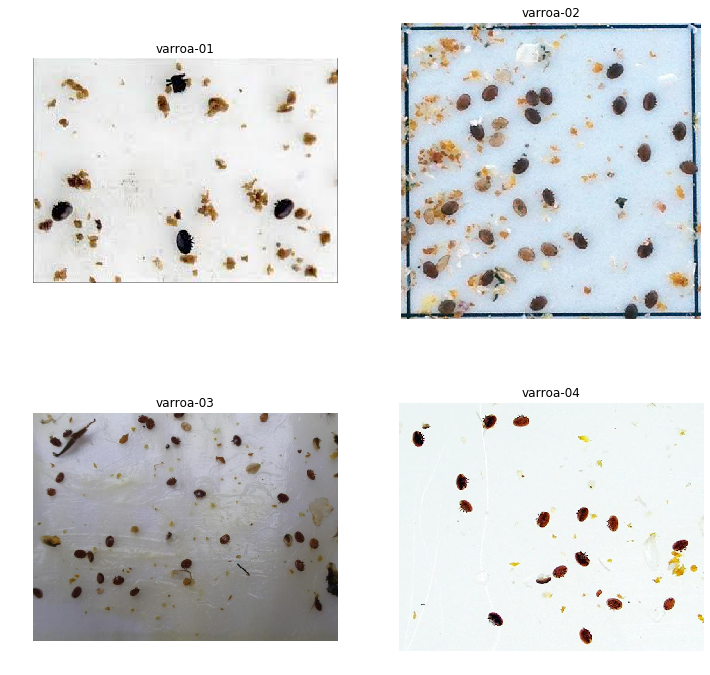

In [4]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [5]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [6]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]